In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv('~/Downloads/a1.csv')

In [35]:
df_cat = pd.read_parquet('../data/total_acorn.gzip')

In [36]:
def cat_change(category):
    if category == "Affluent":
        return 0
    if category == "Comfortable":
        return 1
    if category == "Adversity":
        return 2

# df_cat['Numerical Category'] = df_cat.apply(lambda x: cat_change(x['acorn_category']), axis=1)

new_col = [cat_change(x) for x in df_cat['acorn_category'].values]
df_cat['num_cat'] = new_col

df_cat.head()

,house_id,acorn_group,acorn_category,num_cat
0,MAC000002,ACORN-A,Affluent,0.0
1,MAC000003,ACORN-P,Adversity,2.0
2,MAC000004,ACORN-E,Affluent,0.0
3,MAC000006,ACORN-Q,Adversity,2.0
4,MAC000007,ACORN-H,Comfortable,1.0


In [37]:
df_cat.loc[df_cat['acorn_category'] == 'Comfortable']['num_cat'].unique()

array([1.])

In [38]:
df_cat = df_cat[['house_id','num_cat']]

In [39]:
df_cat.head()

,house_id,num_cat
0,MAC000002,0.0
1,MAC000003,2.0
2,MAC000004,0.0
3,MAC000006,2.0
4,MAC000007,1.0


In [40]:
df_merge = df.merge(df_cat,on='house_id')

In [41]:
cluster_labels = df_merge['num_cat'].values

cluster_vals = df_merge.iloc[:, 1:-1].values

In [29]:
X.shape

(3432, 10)

/Users/sabanejad/Projects/demand-response/venv/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


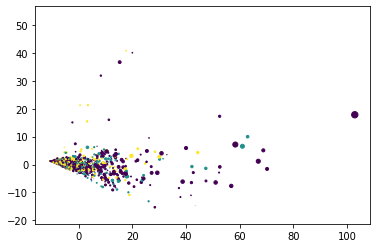

In [42]:
#let's try pca clustering first, just to see if it might work

from sklearn.decomposition import PCA

pca = PCA(n_components= 3)

X = pca.fit_transform(cluster_vals)

plt.figure()
plt.scatter(X[:,0], X[:,1], X[:,2], c=cluster_labels)
# plt.scatter(X[:,0], X[:,1])
plt.show()

#so you can tell munzer that PCA clustering really doesn't seem to work.

/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


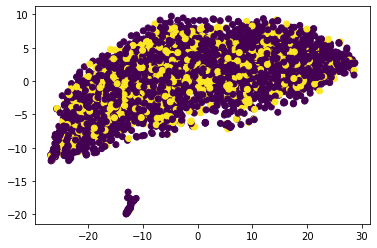

In [38]:
#okay so pca doesn't work very well. Let's try tsne

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

X = tsne.fit_transform(cluster_vals)

plt.figure()
plt.scatter(X[:,0],X[:,1],c = cluster_labels)
plt.show()

#this doesn't work very well either

array([872.5269995 , 205.76531647,  23.00572173,  96.41325467,
       343.26913706,  56.6831643 ,  39.4376516 ,  55.74330587,
       189.87842817,  44.28783242,  87.72763367,  62.36402426,
        63.92338388,  37.91175892,   5.46152547,  19.036055  ,
        12.64505856,  25.35670145,   6.37021768,   5.14659041,
         2.71590048,   9.25416462,   6.06611881,   6.06611881,
         9.25416462,   2.71590048,   5.14659041,   6.37021768,
        25.35670145,  12.64505856,  19.036055  ,   5.46152547,
        37.91175892,  63.92338388,  62.36402426,  87.72763367,
        44.28783242, 189.87842817,  55.74330587,  39.4376516 ,
        56.6831643 , 343.26913706,  96.41325467,  23.00572173,
       205.76531647])

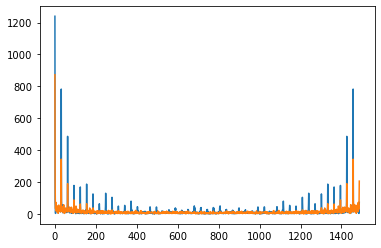

In [48]:
#one more thing to try: maybe we can cluster the freqency response?

from scipy.fft import fft

x = cluster_vals[0,:]
x2= cluster_vals[50,:]

plt.plot(np.abs(fft(x)))
plt.plot(np.abs(fft(x2)))

#what if we just create a function that keeps the top 50 freqs #nope this won't work

vals_to_check = np.where(np.abs(fft(x))>50)

def freq_dim_red(x,vals_to_check):
    
    xfreq = np.abs(fft(x)).flatten()
    return xfreq[tuple(vals_to_check)]

freq_dim_red(x2,vals_to_check=vals_to_check)


#okay this seems to work

In [49]:
X_freq_red = []

for i in range(cluster_vals.shape[0]):
    x = cluster_vals[i,:]
    
    X_freq_red.append(list(freq_dim_red(x,vals_to_check=vals_to_check)))

X_freq_red = np.array(X_freq_red)


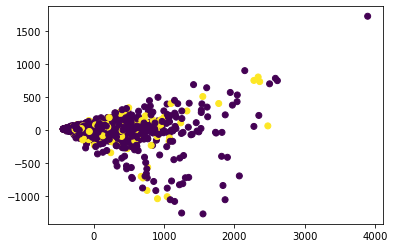

In [51]:
#try clustering again with this data set

pca = PCA(n_components= 2)

X = pca.fit_transform(X_freq_red)

plt.figure()
plt.scatter(X[:,0],X[:,1],c = cluster_labels)
plt.show()

#nope, this still looks bad

/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


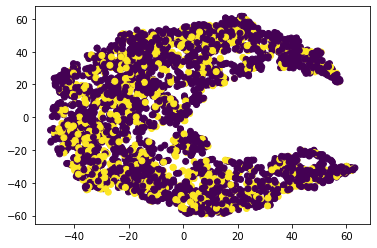

In [52]:
tsne = TSNE(n_components=2)

X = tsne.fit_transform(X_freq_red)

plt.figure()
plt.scatter(X[:,0],X[:,1],c = cluster_labels)
plt.show()

#pretty, but unhelpful


In [62]:
#let's try one more thing, hierarchical clustering:

from sklearn.cluster import AgglomerativeClustering

def dist_calc(x,y):
    #compare average energy use
    return (np.mean(x)-np.mean(x))**2

agg_clust = AgglomerativeClustering(n_clusters = 3) #see if this somehow matches to the


In [63]:
agg_clust.fit(cluster_vals)

print(agg_clust.labels_[:30])

[0 1 1 0 1 2 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1]


In [64]:

df_cat = pd.read_parquet('total_acorn.gzip')
print(df_cat['acorn_category'].values[:30])



#so the above clustering, however you do it, doesn't really recover any recognizable groups
#I would say this argues for just using the preexisting categories.

['Affluent' 'Adversity' 'Affluent' 'Adversity' 'Comfortable' 'Comfortable'
 'Adversity' 'Comfortable' 'Adversity' 'Affluent' 'Adversity' 'Adversity'
 'Affluent' 'Adversity' 'Comfortable' 'Affluent' 'Adversity' 'ACORN-U'
 'Affluent' 'Adversity' 'Affluent' 'Comfortable' 'Affluent' 'Adversity'
 'Affluent' 'Adversity' 'Affluent' 'Affluent' 'Affluent' 'Affluent']
